In [1]:
import torch
import torch.nn as nn
import torchvision
from torchvision import datasets
from torchvision import transforms
import matplotlib.pyplot as plt

import numpy as np
from tqdm import tqdm
import math

In [2]:
transform = transforms.Compose([
                    transforms.ToTensor(), 
                    # transforms.Normalize((0.5,), (0.5,)),
            ])

In [3]:
def CreateDataLoaders(Option, p_BatchSize):
    if Option == 1:
        train_dataset = datasets.MNIST("./", train=True, transform = transform, download=True)
        train_subset, val_subset = torch.utils.data.random_split(train_dataset, [int(len(train_dataset) * 0.85), int(len(train_dataset) * 0.15)], generator=torch.Generator().manual_seed(1))
        test_dataset = datasets.MNIST("./", train=False, transform = transform, download=True)
    elif Option == 2:
        train_dataset = datasets.FashionMNIST("./", train=True, transform = transform, download=True)
        train_subset, val_subset = torch.utils.data.random_split(train_dataset, [int(len(train_dataset) * 0.85), int(len(train_dataset) * 0.15)], generator=torch.Generator().manual_seed(1))
        test_dataset = datasets.FashionMNIST("./", train=False, transform = transform, download=True)
    
    elif Option == 3:
        train_dataset = datasets.STL10("./", split="train", transform = transform, download=True)
        train_subset, val_subset = torch.utils.data.random_split(train_dataset, [int(len(train_dataset) * 0.85), int(len(train_dataset) * 0.15)], generator=torch.Generator().manual_seed(1))
        test_dataset = datasets.STL10("./", split="test", transform = transform, download=True)
    
    elif Option == 4:
        train_dataset = datasets.SVHN("./", split="train", transform = transform, download=True)
        print(len(train_dataset))
        train_subset, val_subset = torch.utils.data.random_split(train_dataset, [int(len(train_dataset) * 0.85), math.ceil(len(train_dataset) * 0.15)], generator=torch.Generator().manual_seed(1))
        test_dataset = datasets.SVHN("./", split="test", transform = transform, download=True)
    
    elif Option == 5:
        train_dataset = datasets.CIFAR10("./", train=True, transform = transform, download=True)
        train_subset, val_subset = torch.utils.data.random_split(train_dataset, [int(len(train_dataset) * 0.85), int(len(train_dataset) * 0.15)], generator=torch.Generator().manual_seed(1))
        test_dataset = datasets.CIFAR10("./", train=False, transform = transform, download=True)

    elif Option == 6:
        train_dataset = datasets.CIFAR100("./", train=True, transform = transform, download=True)
        train_subset, val_subset = torch.utils.data.random_split(train_dataset, [int(len(train_dataset) * 0.85), int(len(train_dataset) * 0.15)], generator=torch.Generator().manual_seed(1))
        test_dataset = datasets.CIFAR100("./", train=False, transform = transform, download=True)

    
    Train_DataLoader = torch.utils.data.DataLoader(train_subset, batch_size = p_BatchSize, shuffle = True)
    Val_DataLoader = torch.utils.data.DataLoader(val_subset, batch_size = p_BatchSize, shuffle = True)
    Test_DataLoader = torch.utils.data.DataLoader(test_dataset, batch_size = p_BatchSize, shuffle = True)

    return Train_DataLoader, Val_DataLoader, Test_DataLoader

In [4]:
def PlotGraph(X, Y1, Y2):
    plt.plot(X, Y1, label = 'Train')
    plt.plot(X, Y2, label = "Val")

    plt.xlabel("Epoch")
    plt.ylabel("Accuracy")

    plt.legend(loc='best')
    plt.show()

In [5]:
class MLP_IOCN(nn.Module):
    def __init__(self, InputDim, OutputDim):
        super(MLP_IOCN, self).__init__()
        self.InputDim = InputDim
        self.OutputDim = OutputDim
        self.Linear1 = nn.Linear(InputDim, 800)
        self.Linear2 = nn.Linear(800, 800)
        self.Linear3 = nn.Linear(800, 800)
        self.Linear4 = nn.Linear(800, self.OutputDim)
        self.ActFunc = nn.functional.elu
        self.batch = nn.BatchNorm1d(800)
        # self.SftMax = nn.functional.softmax

    def forward(self, x):
        x = self.ActFunc(self.batch(self.Linear1(x)))
        x = self.ActFunc(self.batch(self.Linear2(x)))
        x = self.ActFunc(self.batch(self.Linear3(x)))

        output = self.Linear4(x)
        
        return output
    
    # def InitWeights(self):
    #     torch.nn.init.uniform_(self.Linear1.weight,-0.5, 0.5)
    #     torch.nn.init.uniform_(self.Linear2.weight,-0.5, 0.5)

In [6]:
model = MLP_IOCN(100, 10)
for name, param in model.named_parameters():
    print("name=", name)
    # print("param=", param)

name= Linear1.weight
name= Linear1.bias
name= Linear2.weight
name= Linear2.bias
name= Linear3.weight
name= Linear3.bias
name= Linear4.weight
name= Linear4.bias
name= batch.weight
name= batch.bias


In [7]:
def TrainModel(p_model, loss_criteria, Optimizer, device,  p_TrainDL, Gamma = 5):
    TrainCorr = 0
    TotNumOfSamples = 0

    for images, labels in tqdm(p_TrainDL):
        Optimizer.zero_grad()

        images = images.reshape(images.shape[0], -1).to(device)
        labels = labels.to(device)

        pred = p_model(images)
        # print(type(pred))
        # print(pred.shape)
        # print(pred)
        # pred=pred.to(torch.float)
        # labels=labels.to(torch.float)
        predClass = torch.max(pred.data, 1)[1]
        # predClass = np.argmax(pred, axis=-1)
        # predClass = pred.max(1)
        # print("Pred", predClass)
        # print(type(labels))
        # print("labels", labels)

        # predClass=predClass.to(torch.float)
        loss = loss_criteria(pred, labels)
        TrainCorr += (predClass==labels).sum()
        TotNumOfSamples += len(labels)

        loss.backward()
        Optimizer.step()

        # i=0
        # with torch.no_grad():
        #       for params in p_model.parameters():
        #           if i != 0:
        #             newparams=params.detach().clone()
        #             params.copy_(torch.where(newparams < 0, torch.exp(newparams - Gamma), newparams))
        #           i=i+1

        for name, param in p_model.named_parameters():
            # if "Linear1" in name or "bias" in name:
            if "Linear1" in name or "bias" in name or "batch" in name:
                # print(name)
                continue
                
            
            tmpParam = param.data
            NewTmpParam = torch.exp(tmpParam - Gamma)
            tmpParam = torch.where(tmpParam<0, NewTmpParam, tmpParam)
            param.data = tmpParam

            # temp_weight = param.data
            # # temp_weight[temp_weight < 0] = torch.clamp(temp_weight[temp_weight < 0], min=0)
            # temp_weight[temp_weight < 0] = torch.exp(temp_weight[temp_weight < 0])
            # param.data = temp_weight
    
    return TrainCorr/TotNumOfSamples

def EvaluateModel(p_model, p_loader, device):
    Correct = 0
    TotalNumOfSamples = 0

    for images, labels in tqdm(p_loader):
        images = images.reshape(images.shape[0], -1).to(device)
        labels = labels.to(device)

        pred = p_model(images)
        predClass = torch.max(pred.data, 1)[1]
        Correct += (predClass==labels).sum()
        TotalNumOfSamples += len(labels)
        # loss = loss_criteria(predClass, labels)
        # Accuracy += loss.cpu().data.item()

    return Correct/TotalNumOfSamples

In [8]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
EPOCHS = 50

Epoch_List = [i+1 for i in range(EPOCHS)]

In [9]:
# -------------------------------------------- MNIST Dataset -----------------------------------------------------------
Option = 1
Train_DataLoader, Val_DataLoader, Test_DataLoader = CreateDataLoaders(Option, 64)
ModelName = "Model_MLP_IOCN_MNIST.pt"

model = MLP_IOCN(784, 10).to(device)
loss_criteria = nn.CrossEntropyLoss()
AdamOpt = torch.optim.Adam(model.parameters(), lr=0.0001)

ValAccuracy = 0
TrainAcc_List = []
ValAcc_List = []

saved = False
if saved == True:
    saved_model = torch.load(ModelName, map_location=torch.device('cpu')).to(device)
else:
    model.train()
    Train_Accuracy = 0

    for e in range(EPOCHS):
        Train_Accuracy = TrainModel(model, loss_criteria, AdamOpt, device, Train_DataLoader)
        val_acc = EvaluateModel(model, Val_DataLoader, device)
        TrainAcc_List.append(Train_Accuracy.cpu().item())
        ValAcc_List.append(val_acc.cpu().item())

        print("EPOCH - ", e+1, ". Train Accuracy = ", Train_Accuracy.cpu().item(), ", Validation Accuracy = ", val_acc.cpu().item())
        
        if val_acc.cpu().item() > ValAccuracy:
            print("Model Re-Saved")
            ValAccuracy = val_acc.cpu().item()
            torch.save(model, ModelName)


    saved_model = torch.load(ModelName, map_location=torch.device('cpu')).to(device)

print()
Train_Accuracy = EvaluateModel(saved_model, Train_DataLoader, device)
print("Train Accuracy = ", Train_Accuracy.cpu().item())
Test_Accuracy = EvaluateModel(saved_model, Test_DataLoader, device)
print("Test Accuracy = ", Test_Accuracy.cpu().item())

print("Generalization Gap = ", (Train_Accuracy.cpu().item() - Test_Accuracy.cpu().item()))

100%|██████████| 9912422/9912422 [00:00<00:00, 278790250.35it/s]

Extracting ./MNIST/raw/train-images-idx3-ubyte.gz to ./MNIST/raw


100%|██████████| 28881/28881 [00:00<00:00, 26028296.91it/s]


Extracting ./MNIST/raw/train-labels-idx1-ubyte.gz to ./MNIST/raw



100%|██████████| 1648877/1648877 [00:00<00:00, 75619049.35it/s]


Extracting ./MNIST/raw/t10k-images-idx3-ubyte.gz to ./MNIST/raw



100%|██████████| 4542/4542 [00:00<00:00, 21574777.77it/s]

Extracting ./MNIST/raw/t10k-labels-idx1-ubyte.gz to ./MNIST/raw




100%|██████████| 141/141 [00:01<00:00, 87.05it/s]


EPOCH -  1 . Train Accuracy =  0.6436078548431396 , Validation Accuracy =  0.8843333721160889
Model Re-Saved


100%|██████████| 141/141 [00:01<00:00, 109.46it/s]


EPOCH -  2 . Train Accuracy =  0.911980390548706 , Validation Accuracy =  0.9217777848243713
Model Re-Saved


100%|██████████| 141/141 [00:01<00:00, 108.95it/s]


EPOCH -  3 . Train Accuracy =  0.9314314126968384 , Validation Accuracy =  0.9324444532394409
Model Re-Saved


100%|██████████| 141/141 [00:01<00:00, 105.52it/s]


EPOCH -  4 . Train Accuracy =  0.9443333745002747 , Validation Accuracy =  0.9351111054420471
Model Re-Saved


100%|██████████| 141/141 [00:01<00:00, 106.30it/s]


EPOCH -  5 . Train Accuracy =  0.9518039226531982 , Validation Accuracy =  0.945111095905304
Model Re-Saved


100%|██████████| 141/141 [00:01<00:00, 107.45it/s]


EPOCH -  6 . Train Accuracy =  0.9587255120277405 , Validation Accuracy =  0.9528889060020447
Model Re-Saved


100%|██████████| 141/141 [00:01<00:00, 104.51it/s]


EPOCH -  7 . Train Accuracy =  0.9635097980499268 , Validation Accuracy =  0.9524444341659546


100%|██████████| 141/141 [00:01<00:00, 106.21it/s]


EPOCH -  8 . Train Accuracy =  0.9672353267669678 , Validation Accuracy =  0.9510000348091125


100%|██████████| 141/141 [00:02<00:00, 63.30it/s]


EPOCH -  9 . Train Accuracy =  0.9710588455200195 , Validation Accuracy =  0.9547777771949768
Model Re-Saved


100%|██████████| 141/141 [00:01<00:00, 75.45it/s]


EPOCH -  10 . Train Accuracy =  0.9736666679382324 , Validation Accuracy =  0.9572222232818604
Model Re-Saved


100%|██████████| 141/141 [00:01<00:00, 102.35it/s]


EPOCH -  11 . Train Accuracy =  0.9754313826560974 , Validation Accuracy =  0.9578889012336731
Model Re-Saved


100%|██████████| 141/141 [00:01<00:00, 109.50it/s]


EPOCH -  12 . Train Accuracy =  0.9770980477333069 , Validation Accuracy =  0.9631111025810242
Model Re-Saved


100%|██████████| 141/141 [00:01<00:00, 107.64it/s]


EPOCH -  13 . Train Accuracy =  0.9785882830619812 , Validation Accuracy =  0.9641111493110657
Model Re-Saved


100%|██████████| 141/141 [00:01<00:00, 105.65it/s]


EPOCH -  14 . Train Accuracy =  0.9800588488578796 , Validation Accuracy =  0.9621111154556274


100%|██████████| 141/141 [00:01<00:00, 102.72it/s]


EPOCH -  15 . Train Accuracy =  0.9815294146537781 , Validation Accuracy =  0.9628888964653015


100%|██████████| 141/141 [00:01<00:00, 104.76it/s]


EPOCH -  16 . Train Accuracy =  0.9828039407730103 , Validation Accuracy =  0.9636666774749756


100%|██████████| 141/141 [00:01<00:00, 107.51it/s]


EPOCH -  17 . Train Accuracy =  0.9844117760658264 , Validation Accuracy =  0.9637777805328369


100%|██████████| 141/141 [00:01<00:00, 89.23it/s] 


EPOCH -  18 . Train Accuracy =  0.9850784540176392 , Validation Accuracy =  0.9650000333786011
Model Re-Saved


100%|██████████| 141/141 [00:01<00:00, 79.75it/s]


EPOCH -  19 . Train Accuracy =  0.9857451319694519 , Validation Accuracy =  0.9611111283302307


100%|██████████| 141/141 [00:01<00:00, 105.53it/s]


EPOCH -  20 . Train Accuracy =  0.9872745275497437 , Validation Accuracy =  0.9677777886390686
Model Re-Saved


100%|██████████| 141/141 [00:01<00:00, 105.15it/s]


EPOCH -  21 . Train Accuracy =  0.9873529672622681 , Validation Accuracy =  0.9644444584846497


100%|██████████| 141/141 [00:01<00:00, 104.78it/s]


EPOCH -  22 . Train Accuracy =  0.987333357334137 , Validation Accuracy =  0.967555582523346


100%|██████████| 141/141 [00:01<00:00, 105.15it/s]


EPOCH -  23 . Train Accuracy =  0.9878431558609009 , Validation Accuracy =  0.9652222394943237


100%|██████████| 141/141 [00:01<00:00, 106.87it/s]


EPOCH -  24 . Train Accuracy =  0.9897059202194214 , Validation Accuracy =  0.9673333168029785


100%|██████████| 141/141 [00:01<00:00, 104.46it/s]


EPOCH -  25 . Train Accuracy =  0.9895490407943726 , Validation Accuracy =  0.9668889045715332


100%|██████████| 141/141 [00:01<00:00, 105.00it/s]


EPOCH -  26 . Train Accuracy =  0.9888235330581665 , Validation Accuracy =  0.9660000205039978


100%|██████████| 141/141 [00:01<00:00, 100.32it/s]


EPOCH -  27 . Train Accuracy =  0.9902157187461853 , Validation Accuracy =  0.9678888916969299
Model Re-Saved


100%|██████████| 141/141 [00:01<00:00, 74.46it/s]


EPOCH -  28 . Train Accuracy =  0.9905882477760315 , Validation Accuracy =  0.9697777628898621
Model Re-Saved


100%|██████████| 141/141 [00:01<00:00, 92.00it/s]


EPOCH -  29 . Train Accuracy =  0.9914118051528931 , Validation Accuracy =  0.9661111235618591


100%|██████████| 141/141 [00:01<00:00, 102.61it/s]


EPOCH -  30 . Train Accuracy =  0.9909020066261292 , Validation Accuracy =  0.9712222218513489
Model Re-Saved


100%|██████████| 141/141 [00:01<00:00, 105.74it/s]


EPOCH -  31 . Train Accuracy =  0.9904705882072449 , Validation Accuracy =  0.9685555696487427


100%|██████████| 141/141 [00:01<00:00, 106.07it/s]


EPOCH -  32 . Train Accuracy =  0.9925882816314697 , Validation Accuracy =  0.9673333168029785


100%|██████████| 141/141 [00:01<00:00, 105.58it/s]


EPOCH -  33 . Train Accuracy =  0.9925294518470764 , Validation Accuracy =  0.9662222266197205


100%|██████████| 141/141 [00:01<00:00, 106.96it/s]


EPOCH -  34 . Train Accuracy =  0.9921176433563232 , Validation Accuracy =  0.96833336353302


100%|██████████| 141/141 [00:01<00:00, 105.31it/s]


EPOCH -  35 . Train Accuracy =  0.9932941198348999 , Validation Accuracy =  0.9714444279670715
Model Re-Saved


100%|██████████| 141/141 [00:01<00:00, 109.18it/s]


EPOCH -  36 . Train Accuracy =  0.993686318397522 , Validation Accuracy =  0.9678888916969299


100%|██████████| 141/141 [00:01<00:00, 75.44it/s]


EPOCH -  37 . Train Accuracy =  0.9926470518112183 , Validation Accuracy =  0.9694444537162781


100%|██████████| 141/141 [00:01<00:00, 107.70it/s]


EPOCH -  38 . Train Accuracy =  0.9935294389724731 , Validation Accuracy =  0.9668889045715332


100%|██████████| 141/141 [00:01<00:00, 108.75it/s]


EPOCH -  39 . Train Accuracy =  0.993156909942627 , Validation Accuracy =  0.9702222347259521


100%|██████████| 141/141 [00:01<00:00, 108.18it/s]


EPOCH -  40 . Train Accuracy =  0.9942745566368103 , Validation Accuracy =  0.9671111106872559


100%|██████████| 141/141 [00:01<00:00, 107.74it/s]


EPOCH -  41 . Train Accuracy =  0.9939411878585815 , Validation Accuracy =  0.9668889045715332


100%|██████████| 141/141 [00:01<00:00, 107.28it/s]


EPOCH -  42 . Train Accuracy =  0.9946863055229187 , Validation Accuracy =  0.9687777757644653


100%|██████████| 141/141 [00:01<00:00, 107.26it/s]


EPOCH -  43 . Train Accuracy =  0.9937255382537842 , Validation Accuracy =  0.9736666679382324
Model Re-Saved


100%|██████████| 141/141 [00:01<00:00, 100.86it/s]


EPOCH -  44 . Train Accuracy =  0.9932745099067688 , Validation Accuracy =  0.9701111316680908


100%|██████████| 141/141 [00:01<00:00, 76.36it/s]


EPOCH -  45 . Train Accuracy =  0.994882345199585 , Validation Accuracy =  0.968999981880188


100%|██████████| 141/141 [00:01<00:00, 100.26it/s]


EPOCH -  46 . Train Accuracy =  0.9954314231872559 , Validation Accuracy =  0.9697777628898621


100%|██████████| 141/141 [00:01<00:00, 106.18it/s]


EPOCH -  47 . Train Accuracy =  0.9953725934028625 , Validation Accuracy =  0.9695555567741394


100%|██████████| 141/141 [00:01<00:00, 107.73it/s]


EPOCH -  48 . Train Accuracy =  0.994745135307312 , Validation Accuracy =  0.9702222347259521


100%|██████████| 141/141 [00:01<00:00, 103.89it/s]


EPOCH -  49 . Train Accuracy =  0.9953529834747314 , Validation Accuracy =  0.9685555696487427


100%|██████████| 141/141 [00:01<00:00, 108.78it/s]


EPOCH -  50 . Train Accuracy =  0.9945686459541321 , Validation Accuracy =  0.972000002861023



100%|██████████| 797/797 [00:08<00:00, 97.55it/s]


Train Accuracy =  0.9957059025764465


100%|██████████| 157/157 [00:01<00:00, 101.91it/s]

Test Accuracy =  0.97079998254776
Generalization Gap =  0.024905920028686523


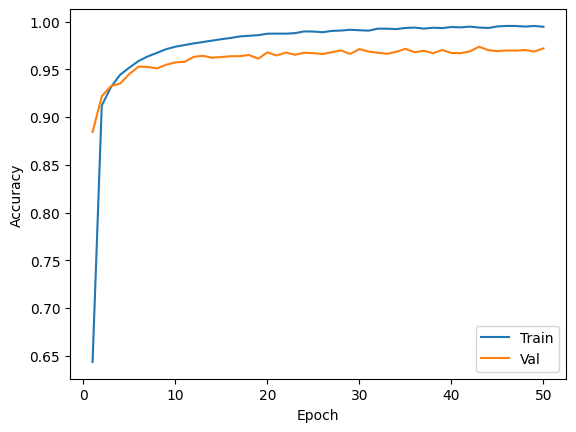

In [10]:
PlotGraph(Epoch_List, TrainAcc_List, ValAcc_List)

In [11]:
# # -------------------------------------------- FMNIST Dataset -----------------------------------------------------------
# Option = 2
# Train_DataLoader, Val_DataLoader, Test_DataLoader = CreateDataLoaders(Option, 64)
# ModelName = "Model_MLP_IOCN_FMNIST.pt"

# model = MLP_IOCN(784, 10).to(device)
# loss_criteria = nn.CrossEntropyLoss()
# AdamOpt = torch.optim.Adam(model.parameters(), lr=0.0001)

# ValAccuracy = 0

# saved = False
# if saved == True:
#     saved_model = torch.load(ModelName, map_location=torch.device('cpu')).to(device)
# else:
#     model.train()
#     Train_Accuracy = 0

#     for e in range(EPOCHS):
#         Train_Accuracy = TrainModel(model, loss_criteria, AdamOpt, device, Train_DataLoader)
#         val_acc = EvaluateModel(model, Val_DataLoader, device)

#         print("EPOCH - ", e+1, ". Train Accuracy = ", Train_Accuracy.cpu().item(), ", Validation Accuracy = ", val_acc.cpu().item())
        
#         if val_acc.cpu().item() > ValAccuracy:
#             print("Model Re-Saved")
#             ValAccuracy = val_acc.cpu().item()
#             torch.save(model, ModelName)


#     saved_model = torch.load(ModelName, map_location=torch.device('cpu')).to(device)

# Train_Accuracy = EvaluateModel(saved_model, Train_DataLoader, device)
# print("Train Accuracy = ", Train_Accuracy.cpu().item())
# Test_Accuracy = EvaluateModel(saved_model, Test_DataLoader, device)
# print("Test Accuracy = ", Test_Accuracy.cpu().item())

# print("Generalization Gap = ", (Train_Accuracy.cpu().item() - Test_Accuracy.cpu().item()))

In [12]:
# -------------------------------------------- FMNIST Dataset -----------------------------------------------------------
Option = 2
Train_DataLoader, Val_DataLoader, Test_DataLoader = CreateDataLoaders(Option, 64)
ModelName = "Model_MLP_IOCN_FMNIST.pt"

model = MLP_IOCN(784, 10).to(device)
loss_criteria = nn.CrossEntropyLoss()
AdamOpt = torch.optim.Adam(model.parameters(), lr=0.0001)

ValAccuracy = 0
TrainAcc_List = []
ValAcc_List = []

saved = False
if saved == True:
    saved_model = torch.load(ModelName, map_location=torch.device('cpu')).to(device)
else:
    model.train()
    Train_Accuracy = 0

    for e in range(EPOCHS):
        Train_Accuracy = TrainModel(model, loss_criteria, AdamOpt, device, Train_DataLoader)
        val_acc = EvaluateModel(model, Val_DataLoader, device)

        TrainAcc_List.append(Train_Accuracy.cpu().item())
        ValAcc_List.append(val_acc.cpu().item())

        print("EPOCH - ", e+1, ". Train Accuracy = ", Train_Accuracy.cpu().item(), ", Validation Accuracy = ", val_acc.cpu().item())
        
        if val_acc.cpu().item() > ValAccuracy:
            print("Model Re-Saved")
            ValAccuracy = val_acc.cpu().item()
            torch.save(model, ModelName)


    saved_model = torch.load(ModelName, map_location=torch.device('cpu')).to(device)

Train_Accuracy = EvaluateModel(saved_model, Train_DataLoader, device)
print("Train Accuracy = ", Train_Accuracy.cpu().item())
Test_Accuracy = EvaluateModel(saved_model, Test_DataLoader, device)
print("Test Accuracy = ", Test_Accuracy.cpu().item())

print("Generalization Gap = ", (Train_Accuracy.cpu().item() - Test_Accuracy.cpu().item()))

100%|██████████| 26421880/26421880 [00:01<00:00, 19746026.92it/s]


Extracting ./FashionMNIST/raw/train-images-idx3-ubyte.gz to ./FashionMNIST/raw



100%|██████████| 29515/29515 [00:00<00:00, 335582.98it/s]


Extracting ./FashionMNIST/raw/train-labels-idx1-ubyte.gz to ./FashionMNIST/raw



100%|██████████| 4422102/4422102 [00:00<00:00, 6071661.96it/s]


Extracting ./FashionMNIST/raw/t10k-images-idx3-ubyte.gz to ./FashionMNIST/raw



100%|██████████| 5148/5148 [00:00<00:00, 7399683.68it/s]


Extracting ./FashionMNIST/raw/t10k-labels-idx1-ubyte.gz to ./FashionMNIST/raw



100%|██████████| 141/141 [00:01<00:00, 107.22it/s]


EPOCH -  1 . Train Accuracy =  0.5131372809410095 , Validation Accuracy =  0.7590000033378601
Model Re-Saved


100%|██████████| 141/141 [00:01<00:00, 103.20it/s]


EPOCH -  2 . Train Accuracy =  0.8019019961357117 , Validation Accuracy =  0.8147777915000916
Model Re-Saved


100%|██████████| 141/141 [00:01<00:00, 107.30it/s]


EPOCH -  3 . Train Accuracy =  0.8296274542808533 , Validation Accuracy =  0.8199999928474426
Model Re-Saved


100%|██████████| 141/141 [00:01<00:00, 104.88it/s]


EPOCH -  4 . Train Accuracy =  0.8424901962280273 , Validation Accuracy =  0.8411111235618591
Model Re-Saved


100%|██████████| 141/141 [00:01<00:00, 79.02it/s]


EPOCH -  5 . Train Accuracy =  0.8503725528717041 , Validation Accuracy =  0.8441111445426941
Model Re-Saved


100%|██████████| 141/141 [00:01<00:00, 91.86it/s]


EPOCH -  6 . Train Accuracy =  0.8596078753471375 , Validation Accuracy =  0.8513333201408386
Model Re-Saved


100%|██████████| 141/141 [00:01<00:00, 107.24it/s]


EPOCH -  7 . Train Accuracy =  0.864627480506897 , Validation Accuracy =  0.851555585861206
Model Re-Saved


100%|██████████| 141/141 [00:01<00:00, 104.56it/s]


EPOCH -  8 . Train Accuracy =  0.8699803948402405 , Validation Accuracy =  0.8562222123146057
Model Re-Saved


100%|██████████| 141/141 [00:01<00:00, 105.70it/s]


EPOCH -  9 . Train Accuracy =  0.8748824000358582 , Validation Accuracy =  0.8628888726234436
Model Re-Saved


100%|██████████| 141/141 [00:01<00:00, 105.21it/s]


EPOCH -  10 . Train Accuracy =  0.8795098066329956 , Validation Accuracy =  0.8617777824401855


100%|██████████| 141/141 [00:01<00:00, 106.61it/s]


EPOCH -  11 . Train Accuracy =  0.8833137154579163 , Validation Accuracy =  0.8586666584014893


100%|██████████| 141/141 [00:01<00:00, 107.04it/s]


EPOCH -  12 . Train Accuracy =  0.8844901919364929 , Validation Accuracy =  0.8596667051315308


100%|██████████| 141/141 [00:01<00:00, 92.32it/s] 


EPOCH -  13 . Train Accuracy =  0.8860196471214294 , Validation Accuracy =  0.8684444427490234
Model Re-Saved


100%|██████████| 141/141 [00:01<00:00, 75.61it/s]


EPOCH -  14 . Train Accuracy =  0.891392171382904 , Validation Accuracy =  0.8669999837875366


100%|██████████| 141/141 [00:01<00:00, 103.18it/s]


EPOCH -  15 . Train Accuracy =  0.893333375453949 , Validation Accuracy =  0.8662222027778625


100%|██████████| 141/141 [00:01<00:00, 107.39it/s]


EPOCH -  16 . Train Accuracy =  0.8940980434417725 , Validation Accuracy =  0.8707777857780457
Model Re-Saved


100%|██████████| 141/141 [00:01<00:00, 104.18it/s]


EPOCH -  17 . Train Accuracy =  0.897725522518158 , Validation Accuracy =  0.8727777600288391
Model Re-Saved


100%|██████████| 141/141 [00:01<00:00, 106.02it/s]


EPOCH -  18 . Train Accuracy =  0.8992549180984497 , Validation Accuracy =  0.8733333349227905
Model Re-Saved


100%|██████████| 141/141 [00:01<00:00, 107.29it/s]


EPOCH -  19 . Train Accuracy =  0.9013921618461609 , Validation Accuracy =  0.8728889226913452


100%|██████████| 141/141 [00:01<00:00, 102.63it/s]


EPOCH -  20 . Train Accuracy =  0.9019215703010559 , Validation Accuracy =  0.8770000338554382
Model Re-Saved


100%|██████████| 141/141 [00:01<00:00, 104.35it/s]


EPOCH -  21 . Train Accuracy =  0.9059804081916809 , Validation Accuracy =  0.874666690826416


100%|██████████| 141/141 [00:01<00:00, 93.26it/s] 


EPOCH -  22 . Train Accuracy =  0.9073529839515686 , Validation Accuracy =  0.8742222189903259


100%|██████████| 141/141 [00:01<00:00, 73.87it/s]


EPOCH -  23 . Train Accuracy =  0.9085490107536316 , Validation Accuracy =  0.8737778067588806


100%|██████████| 141/141 [00:01<00:00, 93.59it/s]


EPOCH -  24 . Train Accuracy =  0.9111961126327515 , Validation Accuracy =  0.8745555877685547


100%|██████████| 141/141 [00:01<00:00, 100.79it/s]


EPOCH -  25 . Train Accuracy =  0.9121960997581482 , Validation Accuracy =  0.8741111159324646


100%|██████████| 141/141 [00:01<00:00, 106.65it/s]


EPOCH -  26 . Train Accuracy =  0.9142941236495972 , Validation Accuracy =  0.8764444589614868


100%|██████████| 141/141 [00:01<00:00, 104.65it/s]


EPOCH -  27 . Train Accuracy =  0.9154509902000427 , Validation Accuracy =  0.8688889145851135


100%|██████████| 141/141 [00:01<00:00, 105.44it/s]


EPOCH -  28 . Train Accuracy =  0.9172549247741699 , Validation Accuracy =  0.8771111369132996
Model Re-Saved


100%|██████████| 141/141 [00:01<00:00, 106.09it/s]


EPOCH -  29 . Train Accuracy =  0.920274555683136 , Validation Accuracy =  0.8777778148651123
Model Re-Saved


100%|██████████| 141/141 [00:01<00:00, 97.60it/s]


EPOCH -  30 . Train Accuracy =  0.9215490221977234 , Validation Accuracy =  0.878000020980835
Model Re-Saved


100%|██████████| 141/141 [00:01<00:00, 104.77it/s]


EPOCH -  31 . Train Accuracy =  0.9220784306526184 , Validation Accuracy =  0.8733333349227905


100%|██████████| 141/141 [00:01<00:00, 85.39it/s] 


EPOCH -  32 . Train Accuracy =  0.9248823523521423 , Validation Accuracy =  0.8785555362701416
Model Re-Saved


100%|██████████| 141/141 [00:01<00:00, 82.38it/s]


EPOCH -  33 . Train Accuracy =  0.9259803891181946 , Validation Accuracy =  0.8815555572509766
Model Re-Saved


100%|██████████| 141/141 [00:01<00:00, 100.79it/s]


EPOCH -  34 . Train Accuracy =  0.927823543548584 , Validation Accuracy =  0.8752222061157227


100%|██████████| 141/141 [00:01<00:00, 104.50it/s]


EPOCH -  35 . Train Accuracy =  0.9302941560745239 , Validation Accuracy =  0.8759999871253967


100%|██████████| 141/141 [00:01<00:00, 104.04it/s]


EPOCH -  36 . Train Accuracy =  0.9303922057151794 , Validation Accuracy =  0.8798888921737671


100%|██████████| 141/141 [00:01<00:00, 106.79it/s]


EPOCH -  37 . Train Accuracy =  0.9312157034873962 , Validation Accuracy =  0.8806666731834412


100%|██████████| 141/141 [00:01<00:00, 104.99it/s]


EPOCH -  38 . Train Accuracy =  0.9334313869476318 , Validation Accuracy =  0.8795555830001831


100%|██████████| 141/141 [00:01<00:00, 103.34it/s]


EPOCH -  39 . Train Accuracy =  0.935039222240448 , Validation Accuracy =  0.8748888969421387


100%|██████████| 141/141 [00:01<00:00, 103.93it/s]


EPOCH -  40 . Train Accuracy =  0.9351568818092346 , Validation Accuracy =  0.8813333511352539


100%|██████████| 141/141 [00:01<00:00, 103.82it/s]


EPOCH -  41 . Train Accuracy =  0.9370588660240173 , Validation Accuracy =  0.8715555667877197


100%|██████████| 141/141 [00:01<00:00, 79.56it/s]


EPOCH -  42 . Train Accuracy =  0.9383137226104736 , Validation Accuracy =  0.8752222061157227


100%|██████████| 141/141 [00:01<00:00, 77.22it/s]


EPOCH -  43 . Train Accuracy =  0.9386863112449646 , Validation Accuracy =  0.8809999823570251


100%|██████████| 141/141 [00:01<00:00, 103.64it/s]


EPOCH -  44 . Train Accuracy =  0.9390000104904175 , Validation Accuracy =  0.8771111369132996


100%|██████████| 141/141 [00:01<00:00, 104.54it/s]


EPOCH -  45 . Train Accuracy =  0.9414314031600952 , Validation Accuracy =  0.8765555620193481


100%|██████████| 141/141 [00:01<00:00, 102.55it/s]


EPOCH -  46 . Train Accuracy =  0.9419608116149902 , Validation Accuracy =  0.8792222142219543


100%|██████████| 141/141 [00:01<00:00, 104.18it/s]


EPOCH -  47 . Train Accuracy =  0.9437059164047241 , Validation Accuracy =  0.8798888921737671


100%|██████████| 141/141 [00:01<00:00, 102.69it/s]


EPOCH -  48 . Train Accuracy =  0.9440784454345703 , Validation Accuracy =  0.8771111369132996


100%|██████████| 141/141 [00:01<00:00, 104.38it/s]


EPOCH -  49 . Train Accuracy =  0.9457058906555176 , Validation Accuracy =  0.8799999952316284


100%|██████████| 141/141 [00:01<00:00, 105.64it/s]


EPOCH -  50 . Train Accuracy =  0.9450588226318359 , Validation Accuracy =  0.8801110982894897


100%|██████████| 797/797 [00:08<00:00, 97.36it/s]


Train Accuracy =  0.9351372718811035


100%|██████████| 157/157 [00:01<00:00, 87.04it/s] 

Test Accuracy =  0.8747999668121338
Generalization Gap =  0.06033730506896973


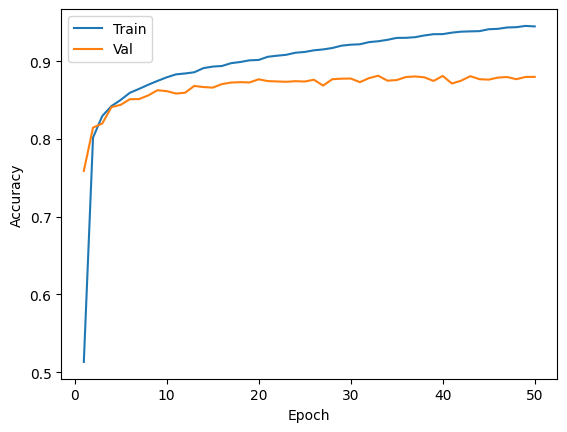

In [13]:
PlotGraph(Epoch_List, TrainAcc_List, ValAcc_List)

In [14]:
# -------------------------------------------- STL 10 Dataset -----------------------------------------------------------
Option = 3
Train_DataLoader, Val_DataLoader, Test_DataLoader = CreateDataLoaders(Option, 64)
ModelName = "Model_MLP_IOCN_STL10.pt"

model = MLP_IOCN(27648, 10).to(device)
loss_criteria = nn.CrossEntropyLoss()
AdamOpt = torch.optim.Adam(model.parameters(), lr=0.0001)

ValAccuracy = 0
TrainAcc_List= []
ValAcc_List= []

saved = False
if saved == True:
    saved_model = torch.load(ModelName, map_location=torch.device('cpu')).to(device)
else:
    model.train()
    Train_Accuracy = 0

    for e in range(EPOCHS):
        Train_Accuracy = TrainModel(model, loss_criteria, AdamOpt, device, Train_DataLoader)
        val_acc = EvaluateModel(model, Val_DataLoader, device)

        TrainAcc_List.append(Train_Accuracy.cpu().item())
        ValAcc_List.append(val_acc.cpu().item())

        print("EPOCH - ", e+1, ". Train Accuracy = ", Train_Accuracy.cpu().item(), ", Validation Accuracy = ", val_acc.cpu().item())
        
        if val_acc.cpu().item() > ValAccuracy:
            print("Model Re-Saved")
            ValAccuracy = val_acc.cpu().item()
            torch.save(model, ModelName)


    saved_model = torch.load(ModelName, map_location=torch.device('cpu')).to(device)

print()
Train_Accuracy = EvaluateModel(saved_model, Train_DataLoader, device)
print("Train Accuracy = ", Train_Accuracy.cpu().item())
Test_Accuracy = EvaluateModel(saved_model, Test_DataLoader, device)
print("Test Accuracy = ", Test_Accuracy.cpu().item())

print("Generalization Gap = ", (Train_Accuracy.cpu().item() - Test_Accuracy.cpu().item()))

100%|██████████| 2640397119/2640397119 [01:06<00:00, 39710076.79it/s]


Extracting ./stl10_binary.tar.gz to ./
Files already downloaded and verified


100%|██████████| 12/12 [00:00<00:00, 34.56it/s]


EPOCH -  1 . Train Accuracy =  0.16094118356704712 , Validation Accuracy =  0.18666666746139526
Model Re-Saved


100%|██████████| 12/12 [00:00<00:00, 35.96it/s]


EPOCH -  2 . Train Accuracy =  0.17717647552490234 , Validation Accuracy =  0.17733332514762878


100%|██████████| 12/12 [00:00<00:00, 34.74it/s]


EPOCH -  3 . Train Accuracy =  0.18352942168712616 , Validation Accuracy =  0.18133333325386047


100%|██████████| 12/12 [00:00<00:00, 35.66it/s]


EPOCH -  4 . Train Accuracy =  0.20282353460788727 , Validation Accuracy =  0.20133332908153534
Model Re-Saved


100%|██████████| 12/12 [00:00<00:00, 36.41it/s]


EPOCH -  5 . Train Accuracy =  0.23905882239341736 , Validation Accuracy =  0.24799999594688416
Model Re-Saved


100%|██████████| 12/12 [00:00<00:00, 35.62it/s]


EPOCH -  6 . Train Accuracy =  0.26376470923423767 , Validation Accuracy =  0.25466665625572205
Model Re-Saved


100%|██████████| 12/12 [00:00<00:00, 23.43it/s]


EPOCH -  7 . Train Accuracy =  0.28564706444740295 , Validation Accuracy =  0.2746666669845581
Model Re-Saved


100%|██████████| 12/12 [00:00<00:00, 35.01it/s]


EPOCH -  8 . Train Accuracy =  0.288470596075058 , Validation Accuracy =  0.2693333327770233


100%|██████████| 12/12 [00:00<00:00, 37.17it/s]


EPOCH -  9 . Train Accuracy =  0.3047058880329132 , Validation Accuracy =  0.281333327293396
Model Re-Saved


100%|██████████| 12/12 [00:00<00:00, 34.25it/s]


EPOCH -  10 . Train Accuracy =  0.32282352447509766 , Validation Accuracy =  0.2773333191871643


100%|██████████| 12/12 [00:00<00:00, 34.08it/s]


EPOCH -  11 . Train Accuracy =  0.32988235354423523 , Validation Accuracy =  0.2840000092983246
Model Re-Saved


100%|██████████| 12/12 [00:00<00:00, 35.63it/s]


EPOCH -  12 . Train Accuracy =  0.3315294086933136 , Validation Accuracy =  0.31066665053367615
Model Re-Saved


100%|██████████| 12/12 [00:00<00:00, 35.96it/s]


EPOCH -  13 . Train Accuracy =  0.35058823227882385 , Validation Accuracy =  0.2653333246707916


100%|██████████| 12/12 [00:00<00:00, 35.31it/s]


EPOCH -  14 . Train Accuracy =  0.3508235514163971 , Validation Accuracy =  0.2879999876022339


100%|██████████| 12/12 [00:00<00:00, 35.59it/s]


EPOCH -  15 . Train Accuracy =  0.36847060918807983 , Validation Accuracy =  0.30533331632614136


100%|██████████| 12/12 [00:00<00:00, 24.82it/s]


EPOCH -  16 . Train Accuracy =  0.3861176669597626 , Validation Accuracy =  0.2786666750907898


100%|██████████| 12/12 [00:00<00:00, 36.17it/s]


EPOCH -  17 . Train Accuracy =  0.39670589566230774 , Validation Accuracy =  0.2773333191871643


100%|██████████| 12/12 [00:00<00:00, 36.64it/s]


EPOCH -  18 . Train Accuracy =  0.41247060894966125 , Validation Accuracy =  0.31066665053367615


100%|██████████| 12/12 [00:00<00:00, 35.21it/s]


EPOCH -  19 . Train Accuracy =  0.43035295605659485 , Validation Accuracy =  0.3226666748523712
Model Re-Saved


100%|██████████| 12/12 [00:00<00:00, 36.04it/s]


EPOCH -  20 . Train Accuracy =  0.4430588185787201 , Validation Accuracy =  0.30133333802223206


100%|██████████| 12/12 [00:00<00:00, 21.86it/s]


EPOCH -  21 . Train Accuracy =  0.45270588994026184 , Validation Accuracy =  0.31466665863990784


100%|██████████| 12/12 [00:00<00:00, 34.68it/s]


EPOCH -  22 . Train Accuracy =  0.4727059006690979 , Validation Accuracy =  0.31200000643730164


100%|██████████| 12/12 [00:00<00:00, 34.22it/s]


EPOCH -  23 . Train Accuracy =  0.4771764874458313 , Validation Accuracy =  0.30666667222976685


100%|██████████| 12/12 [00:00<00:00, 35.76it/s]


EPOCH -  24 . Train Accuracy =  0.49529412388801575 , Validation Accuracy =  0.30399999022483826


100%|██████████| 12/12 [00:00<00:00, 36.11it/s]


EPOCH -  25 . Train Accuracy =  0.48941177129745483 , Validation Accuracy =  0.31333333253860474


100%|██████████| 12/12 [00:00<00:00, 34.00it/s]


EPOCH -  26 . Train Accuracy =  0.5204706192016602 , Validation Accuracy =  0.3240000009536743
Model Re-Saved


100%|██████████| 12/12 [00:00<00:00, 33.14it/s]


EPOCH -  27 . Train Accuracy =  0.5364705920219421 , Validation Accuracy =  0.2906666696071625


100%|██████████| 12/12 [00:00<00:00, 35.00it/s]


EPOCH -  28 . Train Accuracy =  0.551764726638794 , Validation Accuracy =  0.3319999873638153
Model Re-Saved


100%|██████████| 12/12 [00:00<00:00, 32.97it/s]


EPOCH -  29 . Train Accuracy =  0.5665882229804993 , Validation Accuracy =  0.29600000381469727


100%|██████████| 12/12 [00:00<00:00, 24.21it/s]


EPOCH -  30 . Train Accuracy =  0.5724706053733826 , Validation Accuracy =  0.3240000009536743


100%|██████████| 12/12 [00:00<00:00, 34.43it/s]


EPOCH -  31 . Train Accuracy =  0.5799999833106995 , Validation Accuracy =  0.30933332443237305


100%|██████████| 12/12 [00:00<00:00, 34.90it/s]


EPOCH -  32 . Train Accuracy =  0.6197647452354431 , Validation Accuracy =  0.29866665601730347


100%|██████████| 12/12 [00:00<00:00, 34.97it/s]


EPOCH -  33 . Train Accuracy =  0.6232941150665283 , Validation Accuracy =  0.3173333406448364


100%|██████████| 12/12 [00:00<00:00, 34.89it/s]


EPOCH -  34 . Train Accuracy =  0.6310588121414185 , Validation Accuracy =  0.31599998474121094


100%|██████████| 12/12 [00:00<00:00, 24.06it/s]


EPOCH -  35 . Train Accuracy =  0.6548235416412354 , Validation Accuracy =  0.29466667771339417


100%|██████████| 12/12 [00:00<00:00, 35.72it/s]


EPOCH -  36 . Train Accuracy =  0.6571764945983887 , Validation Accuracy =  0.31200000643730164


100%|██████████| 12/12 [00:00<00:00, 35.61it/s]


EPOCH -  37 . Train Accuracy =  0.6743529438972473 , Validation Accuracy =  0.2826666533946991


100%|██████████| 12/12 [00:00<00:00, 35.89it/s]


EPOCH -  38 . Train Accuracy =  0.6585882306098938 , Validation Accuracy =  0.3319999873638153


100%|██████████| 12/12 [00:00<00:00, 35.92it/s]


EPOCH -  39 . Train Accuracy =  0.7047058939933777 , Validation Accuracy =  0.30666667222976685


100%|██████████| 12/12 [00:00<00:00, 23.92it/s]


EPOCH -  40 . Train Accuracy =  0.7164705991744995 , Validation Accuracy =  0.31333333253860474


100%|██████████| 12/12 [00:00<00:00, 35.61it/s]


EPOCH -  41 . Train Accuracy =  0.7268235683441162 , Validation Accuracy =  0.29866665601730347


100%|██████████| 12/12 [00:00<00:00, 34.68it/s]


EPOCH -  42 . Train Accuracy =  0.7308235168457031 , Validation Accuracy =  0.3199999928474426


100%|██████████| 12/12 [00:00<00:00, 35.23it/s]


EPOCH -  43 . Train Accuracy =  0.7428235411643982 , Validation Accuracy =  0.3213333189487457


100%|██████████| 12/12 [00:00<00:00, 34.69it/s]


EPOCH -  44 . Train Accuracy =  0.7291764616966248 , Validation Accuracy =  0.2879999876022339


100%|██████████| 12/12 [00:00<00:00, 35.55it/s]


EPOCH -  45 . Train Accuracy =  0.7729411721229553 , Validation Accuracy =  0.29466667771339417


100%|██████████| 12/12 [00:00<00:00, 34.43it/s]


EPOCH -  46 . Train Accuracy =  0.7771764993667603 , Validation Accuracy =  0.2906666696071625


100%|██████████| 12/12 [00:00<00:00, 34.80it/s]


EPOCH -  47 . Train Accuracy =  0.7807059288024902 , Validation Accuracy =  0.2866666615009308


100%|██████████| 12/12 [00:00<00:00, 34.51it/s]


EPOCH -  48 . Train Accuracy =  0.7929412126541138 , Validation Accuracy =  0.2893333435058594


100%|██████████| 12/12 [00:00<00:00, 23.36it/s]


EPOCH -  49 . Train Accuracy =  0.7969412207603455 , Validation Accuracy =  0.31333333253860474


100%|██████████| 12/12 [00:00<00:00, 35.39it/s]


EPOCH -  50 . Train Accuracy =  0.8065882325172424 , Validation Accuracy =  0.29999998211860657



100%|██████████| 67/67 [00:01<00:00, 35.03it/s]


Train Accuracy =  0.560235321521759


100%|██████████| 125/125 [00:03<00:00, 34.56it/s]

Test Accuracy =  0.3160000145435333
Generalization Gap =  0.2442353069782257


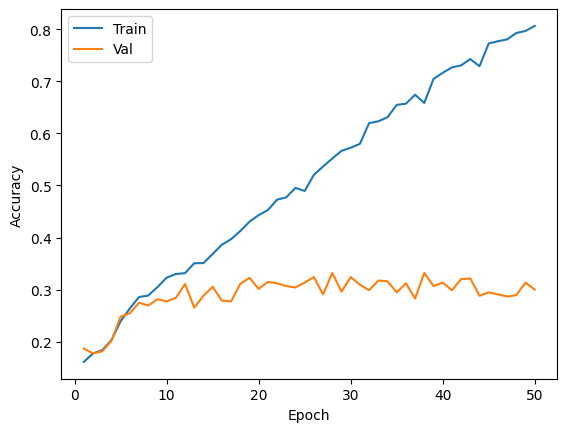

In [15]:
PlotGraph(Epoch_List, TrainAcc_List, ValAcc_List)

In [16]:
# -------------------------------------------- SVHN Dataset -----------------------------------------------------------
Option = 4
Train_DataLoader, Val_DataLoader, Test_DataLoader = CreateDataLoaders(Option, 64)
ModelName = "Model_MLP_IOCN_SVHN.pt"

model = MLP_IOCN(3072, 10).to(device)
loss_criteria = nn.CrossEntropyLoss()
AdamOpt = torch.optim.Adam(model.parameters(), lr=0.0001)

ValAccuracy = 0
TrainAcc_List= []
ValAcc_List= []

saved = False
if saved == True:
    saved_model = torch.load(ModelName, map_location=torch.device('cpu')).to(device)
else:
    model.train()
    Train_Accuracy = 0

    for e in range(EPOCHS):
        Train_Accuracy = TrainModel(model, loss_criteria, AdamOpt, device, Train_DataLoader)
        val_acc = EvaluateModel(model, Val_DataLoader, device)

        TrainAcc_List.append(Train_Accuracy.cpu().item())
        ValAcc_List.append(val_acc.cpu().item())

        print("EPOCH - ", e+1, ". Train Accuracy = ", Train_Accuracy.cpu().item(), ", Validation Accuracy = ", val_acc.cpu().item())
        
        if val_acc.cpu().item() > ValAccuracy:
            print("Model Re-Saved")
            ValAccuracy = val_acc.cpu().item()
            torch.save(model, ModelName)


    saved_model = torch.load(ModelName, map_location=torch.device('cpu')).to(device)

print()
Train_Accuracy = EvaluateModel(saved_model, Train_DataLoader, device)
print("Train Accuracy = ", Train_Accuracy.cpu().item())
Test_Accuracy = EvaluateModel(saved_model, Test_DataLoader, device)
print("Test Accuracy = ", Test_Accuracy.cpu().item())

print("Generalization Gap = ", (Train_Accuracy.cpu().item() - Test_Accuracy.cpu().item()))

100%|██████████| 182040794/182040794 [00:05<00:00, 31886255.29it/s]


73257


100%|██████████| 172/172 [00:02<00:00, 64.57it/s]


EPOCH -  1 . Train Accuracy =  0.2154557704925537 , Validation Accuracy =  0.2603512406349182
Model Re-Saved


100%|██████████| 172/172 [00:02<00:00, 83.42it/s]


EPOCH -  2 . Train Accuracy =  0.30352669954299927 , Validation Accuracy =  0.34452635049819946
Model Re-Saved


100%|██████████| 172/172 [00:02<00:00, 77.47it/s]


EPOCH -  3 . Train Accuracy =  0.34929659962654114 , Validation Accuracy =  0.3581763505935669
Model Re-Saved


100%|██████████| 172/172 [00:02<00:00, 72.15it/s]


EPOCH -  4 . Train Accuracy =  0.41779085993766785 , Validation Accuracy =  0.4583674371242523
Model Re-Saved


100%|██████████| 172/172 [00:02<00:00, 84.45it/s]


EPOCH -  5 . Train Accuracy =  0.484582781791687 , Validation Accuracy =  0.5086904764175415
Model Re-Saved


100%|██████████| 172/172 [00:02<00:00, 81.81it/s]


EPOCH -  6 . Train Accuracy =  0.5309629440307617 , Validation Accuracy =  0.5402675271034241
Model Re-Saved


100%|██████████| 172/172 [00:02<00:00, 82.94it/s]


EPOCH -  7 . Train Accuracy =  0.5781621336936951 , Validation Accuracy =  0.5990535616874695
Model Re-Saved


100%|██████████| 172/172 [00:02<00:00, 82.01it/s]


EPOCH -  8 . Train Accuracy =  0.6152437925338745 , Validation Accuracy =  0.6379106044769287
Model Re-Saved


100%|██████████| 172/172 [00:02<00:00, 72.16it/s]


EPOCH -  9 . Train Accuracy =  0.6374703049659729 , Validation Accuracy =  0.6470106244087219
Model Re-Saved


100%|██████████| 172/172 [00:02<00:00, 81.61it/s]


EPOCH -  10 . Train Accuracy =  0.6581711769104004 , Validation Accuracy =  0.6634816527366638
Model Re-Saved


100%|██████████| 172/172 [00:02<00:00, 83.37it/s]


EPOCH -  11 . Train Accuracy =  0.6736686825752258 , Validation Accuracy =  0.6704886555671692
Model Re-Saved


100%|██████████| 172/172 [00:02<00:00, 65.67it/s]


EPOCH -  12 . Train Accuracy =  0.6866448521614075 , Validation Accuracy =  0.6865956783294678
Model Re-Saved


100%|██████████| 172/172 [00:02<00:00, 84.11it/s]


EPOCH -  13 . Train Accuracy =  0.7014036178588867 , Validation Accuracy =  0.6944217085838318
Model Re-Saved


100%|██████████| 172/172 [00:02<00:00, 82.83it/s]


EPOCH -  14 . Train Accuracy =  0.7119547724723816 , Validation Accuracy =  0.6959686875343323
Model Re-Saved


100%|██████████| 172/172 [00:02<00:00, 62.68it/s]


EPOCH -  15 . Train Accuracy =  0.7219599485397339 , Validation Accuracy =  0.7248157262802124
Model Re-Saved


100%|██████████| 172/172 [00:02<00:00, 78.66it/s]


EPOCH -  16 . Train Accuracy =  0.7302467226982117 , Validation Accuracy =  0.7158067226409912


100%|██████████| 172/172 [00:02<00:00, 81.34it/s]


EPOCH -  17 . Train Accuracy =  0.7366544604301453 , Validation Accuracy =  0.7218127250671387


100%|██████████| 172/172 [00:02<00:00, 69.92it/s]


EPOCH -  18 . Train Accuracy =  0.7448930740356445 , Validation Accuracy =  0.7283647060394287
Model Re-Saved


100%|██████████| 172/172 [00:02<00:00, 83.38it/s]


EPOCH -  19 . Train Accuracy =  0.75030517578125 , Validation Accuracy =  0.7390117049217224
Model Re-Saved


100%|██████████| 172/172 [00:02<00:00, 85.20it/s]


EPOCH -  20 . Train Accuracy =  0.7544164061546326 , Validation Accuracy =  0.736372709274292


100%|██████████| 172/172 [00:02<00:00, 73.09it/s]


EPOCH -  21 . Train Accuracy =  0.7591540217399597 , Validation Accuracy =  0.7323687076568604


100%|██████████| 172/172 [00:01<00:00, 86.54it/s]


EPOCH -  22 . Train Accuracy =  0.7633455395698547 , Validation Accuracy =  0.7401947379112244
Model Re-Saved


100%|██████████| 172/172 [00:02<00:00, 85.72it/s]


EPOCH -  23 . Train Accuracy =  0.7669589519500732 , Validation Accuracy =  0.7479297518730164
Model Re-Saved


100%|██████████| 172/172 [00:02<00:00, 71.95it/s]


EPOCH -  24 . Train Accuracy =  0.773479163646698 , Validation Accuracy =  0.7597597241401672
Model Re-Saved


100%|██████████| 172/172 [00:02<00:00, 81.71it/s]


EPOCH -  25 . Train Accuracy =  0.7758238911628723 , Validation Accuracy =  0.7604877352714539
Model Re-Saved


100%|██████████| 172/172 [00:02<00:00, 82.22it/s]


EPOCH -  26 . Train Accuracy =  0.7794051766395569 , Validation Accuracy =  0.733187735080719


100%|██████████| 172/172 [00:02<00:00, 80.54it/s]


EPOCH -  27 . Train Accuracy =  0.7807862758636475 , Validation Accuracy =  0.7648557424545288
Model Re-Saved


100%|██████████| 172/172 [00:02<00:00, 81.79it/s]


EPOCH -  28 . Train Accuracy =  0.7859896421432495 , Validation Accuracy =  0.7684047222137451
Model Re-Saved


100%|██████████| 172/172 [00:02<00:00, 80.85it/s]


EPOCH -  29 . Train Accuracy =  0.7885912656784058 , Validation Accuracy =  0.778323769569397
Model Re-Saved


100%|██████████| 172/172 [00:02<00:00, 81.83it/s]


EPOCH -  30 . Train Accuracy =  0.7925419211387634 , Validation Accuracy =  0.7669487595558167


100%|██████████| 172/172 [00:02<00:00, 84.45it/s]


EPOCH -  31 . Train Accuracy =  0.793393075466156 , Validation Accuracy =  0.7538447380065918


100%|██████████| 172/172 [00:02<00:00, 84.20it/s]


EPOCH -  32 . Train Accuracy =  0.7955772280693054 , Validation Accuracy =  0.7709527611732483


100%|██████████| 172/172 [00:02<00:00, 83.88it/s]


EPOCH -  33 . Train Accuracy =  0.7972634434700012 , Validation Accuracy =  0.7735007405281067


100%|██████████| 172/172 [00:02<00:00, 85.66it/s]


EPOCH -  34 . Train Accuracy =  0.7991424202919006 , Validation Accuracy =  0.7804167866706848
Model Re-Saved


100%|██████████| 172/172 [00:02<00:00, 84.86it/s]


EPOCH -  35 . Train Accuracy =  0.801455020904541 , Validation Accuracy =  0.7686777710914612


100%|██████████| 172/172 [00:02<00:00, 83.10it/s]


EPOCH -  36 . Train Accuracy =  0.8038639426231384 , Validation Accuracy =  0.7825097441673279
Model Re-Saved


100%|██████████| 172/172 [00:02<00:00, 83.14it/s]


EPOCH -  37 . Train Accuracy =  0.8061605095863342 , Validation Accuracy =  0.7761397361755371


100%|██████████| 172/172 [00:02<00:00, 85.56it/s]


EPOCH -  38 . Train Accuracy =  0.8082000613212585 , Validation Accuracy =  0.7841477394104004
Model Re-Saved


100%|██████████| 172/172 [00:02<00:00, 78.48it/s]


EPOCH -  39 . Train Accuracy =  0.8118616342544556 , Validation Accuracy =  0.7871507406234741
Model Re-Saved


100%|██████████| 172/172 [00:02<00:00, 81.75it/s]


EPOCH -  40 . Train Accuracy =  0.8110426068305969 , Validation Accuracy =  0.7843297719955444


100%|██████████| 172/172 [00:02<00:00, 83.85it/s]


EPOCH -  41 . Train Accuracy =  0.8146721124649048 , Validation Accuracy =  0.7841477394104004


100%|██████████| 172/172 [00:02<00:00, 78.28it/s]


EPOCH -  42 . Train Accuracy =  0.8139494061470032 , Validation Accuracy =  0.7949767708778381
Model Re-Saved


100%|██████████| 172/172 [00:02<00:00, 84.46it/s]


EPOCH -  43 . Train Accuracy =  0.8161656260490417 , Validation Accuracy =  0.7845117449760437


100%|██████████| 172/172 [00:02<00:00, 83.21it/s]


EPOCH -  44 . Train Accuracy =  0.8177233934402466 , Validation Accuracy =  0.7914277911186218


100%|██████████| 172/172 [00:02<00:00, 84.01it/s]


EPOCH -  45 . Train Accuracy =  0.8203732371330261 , Validation Accuracy =  0.7878787517547607


100%|██████████| 172/172 [00:02<00:00, 83.33it/s]


EPOCH -  46 . Train Accuracy =  0.8222843408584595 , Validation Accuracy =  0.7904267907142639


100%|██████████| 172/172 [00:02<00:00, 84.42it/s]


EPOCH -  47 . Train Accuracy =  0.823135495185852 , Validation Accuracy =  0.7946127653121948


100%|██████████| 172/172 [00:02<00:00, 82.78it/s]


EPOCH -  48 . Train Accuracy =  0.8238903284072876 , Validation Accuracy =  0.797160804271698
Model Re-Saved


100%|██████████| 172/172 [00:01<00:00, 86.51it/s]


EPOCH -  49 . Train Accuracy =  0.8232479095458984 , Validation Accuracy =  0.7956137657165527


100%|██████████| 172/172 [00:02<00:00, 83.22it/s]


EPOCH -  50 . Train Accuracy =  0.8274233937263489 , Validation Accuracy =  0.7995268106460571
Model Re-Saved



100%|██████████| 973/973 [00:12<00:00, 78.40it/s]


Train Accuracy =  0.8419734239578247


100%|██████████| 407/407 [00:05<00:00, 70.45it/s]

Test Accuracy =  0.7707052826881409
Generalization Gap =  0.07126814126968384


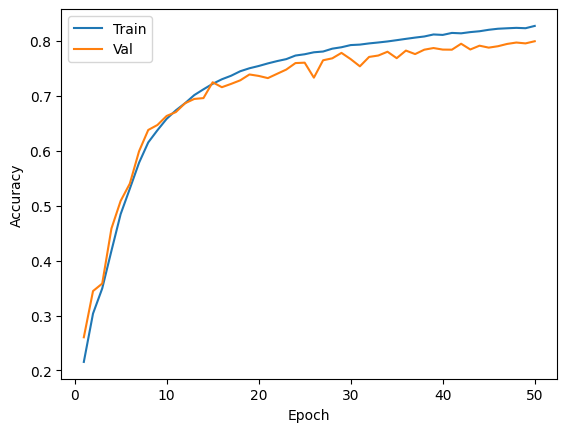

In [17]:
PlotGraph(Epoch_List, TrainAcc_List, ValAcc_List)

In [18]:
# -------------------------------------------- CIFAR-10 Dataset -----------------------------------------------------------
Option = 5
Train_DataLoader, Val_DataLoader, Test_DataLoader = CreateDataLoaders(Option, 64)
ModelName = "Model_MLP_IOCN_CIFAR10.pt"

model = MLP_IOCN(3072, 10).to(device)
loss_criteria = nn.CrossEntropyLoss()
AdamOpt = torch.optim.Adam(model.parameters(), lr=0.0001)

ValAccuracy = 0
TrainAcc_List = []
ValAcc_List = []

saved = False
if saved == True:
    saved_model = torch.load(ModelName, map_location=torch.device('cpu')).to(device)
else:
    model.train()
    Train_Accuracy = 0

    for e in range(EPOCHS):
        Train_Accuracy = TrainModel(model, loss_criteria, AdamOpt, device, Train_DataLoader)
        val_acc = EvaluateModel(model, Val_DataLoader, device)

        TrainAcc_List.append(Train_Accuracy.cpu().item())
        ValAcc_List.append(val_acc.cpu().item())

        print("EPOCH - ", e+1, ". Train Accuracy = ", Train_Accuracy.cpu().item(), ", Validation Accuracy = ", val_acc.cpu().item())
        
        if val_acc.cpu().item() > ValAccuracy:
            print("Model Re-Saved")
            ValAccuracy = val_acc.cpu().item()
            torch.save(model, ModelName)

    saved_model = torch.load(ModelName, map_location=torch.device('cpu')).to(device)


print()

Train_Accuracy = EvaluateModel(saved_model, Train_DataLoader, device)
print("Train Accuracy = ", Train_Accuracy.cpu().item())
Test_Accuracy = EvaluateModel(saved_model, Test_DataLoader, device)
print("Test Accuracy = ", Test_Accuracy.cpu().item())

print("Generalization Gap = ", (Train_Accuracy.cpu().item() - Test_Accuracy.cpu().item()))

100%|██████████| 170498071/170498071 [00:01<00:00, 104499735.53it/s]


Extracting ./cifar-10-python.tar.gz to ./
Files already downloaded and verified


100%|██████████| 118/118 [00:01<00:00, 85.14it/s]


EPOCH -  1 . Train Accuracy =  0.2193882316350937 , Validation Accuracy =  0.2847999930381775
Model Re-Saved


100%|██████████| 118/118 [00:01<00:00, 86.55it/s]


EPOCH -  2 . Train Accuracy =  0.29811763763427734 , Validation Accuracy =  0.32199999690055847
Model Re-Saved


100%|██████████| 118/118 [00:01<00:00, 86.76it/s]


EPOCH -  3 . Train Accuracy =  0.3511764705181122 , Validation Accuracy =  0.3702666759490967
Model Re-Saved


100%|██████████| 118/118 [00:01<00:00, 85.68it/s]


EPOCH -  4 . Train Accuracy =  0.3787294030189514 , Validation Accuracy =  0.38493335247039795
Model Re-Saved


100%|██████████| 118/118 [00:01<00:00, 88.40it/s]


EPOCH -  5 . Train Accuracy =  0.39729413390159607 , Validation Accuracy =  0.3869333267211914
Model Re-Saved


100%|██████████| 118/118 [00:01<00:00, 80.21it/s]


EPOCH -  6 . Train Accuracy =  0.4135529398918152 , Validation Accuracy =  0.40346667170524597
Model Re-Saved


100%|██████████| 118/118 [00:01<00:00, 66.94it/s]


EPOCH -  7 . Train Accuracy =  0.4300941228866577 , Validation Accuracy =  0.4164000153541565
Model Re-Saved


100%|██████████| 118/118 [00:01<00:00, 87.32it/s]


EPOCH -  8 . Train Accuracy =  0.44294118881225586 , Validation Accuracy =  0.42160001397132874
Model Re-Saved


100%|██████████| 118/118 [00:01<00:00, 89.46it/s]


EPOCH -  9 . Train Accuracy =  0.45621177554130554 , Validation Accuracy =  0.4306666851043701
Model Re-Saved


100%|██████████| 118/118 [00:01<00:00, 87.40it/s]


EPOCH -  10 . Train Accuracy =  0.46449410915374756 , Validation Accuracy =  0.4370666742324829
Model Re-Saved


100%|██████████| 118/118 [00:01<00:00, 88.86it/s]


EPOCH -  11 . Train Accuracy =  0.4755529463291168 , Validation Accuracy =  0.4426666796207428
Model Re-Saved


100%|██████████| 118/118 [00:01<00:00, 88.16it/s]


EPOCH -  12 . Train Accuracy =  0.48701176047325134 , Validation Accuracy =  0.4496000111103058
Model Re-Saved


100%|██████████| 118/118 [00:01<00:00, 86.01it/s]


EPOCH -  13 . Train Accuracy =  0.49447059631347656 , Validation Accuracy =  0.45080000162124634
Model Re-Saved


100%|██████████| 118/118 [00:01<00:00, 87.26it/s]


EPOCH -  14 . Train Accuracy =  0.5044000148773193 , Validation Accuracy =  0.4662666618824005
Model Re-Saved


100%|██████████| 118/118 [00:01<00:00, 60.59it/s]


EPOCH -  15 . Train Accuracy =  0.5126823782920837 , Validation Accuracy =  0.47466668486595154
Model Re-Saved


100%|██████████| 118/118 [00:01<00:00, 79.99it/s]


EPOCH -  16 . Train Accuracy =  0.520799994468689 , Validation Accuracy =  0.4588000178337097


100%|██████████| 118/118 [00:01<00:00, 87.42it/s]


EPOCH -  17 . Train Accuracy =  0.5232470631599426 , Validation Accuracy =  0.4774666726589203
Model Re-Saved


100%|██████████| 118/118 [00:01<00:00, 87.48it/s]


EPOCH -  18 . Train Accuracy =  0.5311529636383057 , Validation Accuracy =  0.47866666316986084
Model Re-Saved


100%|██████████| 118/118 [00:01<00:00, 86.57it/s]


EPOCH -  19 . Train Accuracy =  0.5386117696762085 , Validation Accuracy =  0.47733333706855774


100%|██████████| 118/118 [00:01<00:00, 88.57it/s]


EPOCH -  20 . Train Accuracy =  0.5441411733627319 , Validation Accuracy =  0.4761333465576172


100%|██████████| 118/118 [00:01<00:00, 87.54it/s]


EPOCH -  21 . Train Accuracy =  0.5497412085533142 , Validation Accuracy =  0.4801333248615265
Model Re-Saved


100%|██████████| 118/118 [00:01<00:00, 87.93it/s]


EPOCH -  22 . Train Accuracy =  0.5550588369369507 , Validation Accuracy =  0.4761333465576172


100%|██████████| 118/118 [00:01<00:00, 62.58it/s]


EPOCH -  23 . Train Accuracy =  0.5642117857933044 , Validation Accuracy =  0.4875999987125397
Model Re-Saved


100%|██████████| 118/118 [00:01<00:00, 90.39it/s]


EPOCH -  24 . Train Accuracy =  0.5651059150695801 , Validation Accuracy =  0.48559999465942383


100%|██████████| 118/118 [00:01<00:00, 90.40it/s]


EPOCH -  25 . Train Accuracy =  0.5726588368415833 , Validation Accuracy =  0.48266667127609253


100%|██████████| 118/118 [00:01<00:00, 89.53it/s]


EPOCH -  26 . Train Accuracy =  0.5735764503479004 , Validation Accuracy =  0.48373332619667053


100%|██████████| 118/118 [00:01<00:00, 88.40it/s]


EPOCH -  27 . Train Accuracy =  0.5813646912574768 , Validation Accuracy =  0.4830666780471802


100%|██████████| 118/118 [00:01<00:00, 88.88it/s]


EPOCH -  28 . Train Accuracy =  0.5851529240608215 , Validation Accuracy =  0.48373332619667053


100%|██████████| 118/118 [00:01<00:00, 88.62it/s]


EPOCH -  29 . Train Accuracy =  0.5886588096618652 , Validation Accuracy =  0.4817333519458771


100%|██████████| 118/118 [00:01<00:00, 73.85it/s]


EPOCH -  30 . Train Accuracy =  0.5880235433578491 , Validation Accuracy =  0.4858666658401489


100%|██████████| 118/118 [00:01<00:00, 67.67it/s]


EPOCH -  31 . Train Accuracy =  0.6002588272094727 , Validation Accuracy =  0.4857333302497864


100%|██████████| 118/118 [00:01<00:00, 91.84it/s]


EPOCH -  32 . Train Accuracy =  0.6065647006034851 , Validation Accuracy =  0.5040000081062317
Model Re-Saved


100%|██████████| 118/118 [00:01<00:00, 86.94it/s]


EPOCH -  33 . Train Accuracy =  0.6089176535606384 , Validation Accuracy =  0.4841333329677582


100%|██████████| 118/118 [00:01<00:00, 88.21it/s]


EPOCH -  34 . Train Accuracy =  0.6094353199005127 , Validation Accuracy =  0.4984000027179718


100%|██████████| 118/118 [00:01<00:00, 88.33it/s]


EPOCH -  35 . Train Accuracy =  0.6166353225708008 , Validation Accuracy =  0.5009333491325378


100%|██████████| 118/118 [00:01<00:00, 86.57it/s]


EPOCH -  36 . Train Accuracy =  0.6228235363960266 , Validation Accuracy =  0.4949333369731903


100%|██████████| 118/118 [00:01<00:00, 88.61it/s]


EPOCH -  37 . Train Accuracy =  0.624258816242218 , Validation Accuracy =  0.5002666711807251


100%|██████████| 118/118 [00:01<00:00, 70.16it/s]


EPOCH -  38 . Train Accuracy =  0.6264941096305847 , Validation Accuracy =  0.5029333233833313


100%|██████████| 118/118 [00:01<00:00, 71.05it/s]


EPOCH -  39 . Train Accuracy =  0.6342353224754333 , Validation Accuracy =  0.5018666982650757


100%|██████████| 118/118 [00:01<00:00, 89.84it/s]


EPOCH -  40 . Train Accuracy =  0.6393176317214966 , Validation Accuracy =  0.4949333369731903


100%|██████████| 118/118 [00:01<00:00, 89.13it/s]


EPOCH -  41 . Train Accuracy =  0.6435999870300293 , Validation Accuracy =  0.5030666589736938


100%|██████████| 118/118 [00:01<00:00, 89.23it/s]


EPOCH -  42 . Train Accuracy =  0.6449646949768066 , Validation Accuracy =  0.5005333423614502


100%|██████████| 118/118 [00:01<00:00, 83.20it/s]


EPOCH -  43 . Train Accuracy =  0.6510117650032043 , Validation Accuracy =  0.5013333559036255


100%|██████████| 118/118 [00:01<00:00, 88.53it/s]


EPOCH -  44 . Train Accuracy =  0.6537176370620728 , Validation Accuracy =  0.5065333247184753
Model Re-Saved


100%|██████████| 118/118 [00:01<00:00, 88.88it/s]


EPOCH -  45 . Train Accuracy =  0.6547529697418213 , Validation Accuracy =  0.5076000094413757
Model Re-Saved


100%|██████████| 118/118 [00:01<00:00, 70.44it/s]


EPOCH -  46 . Train Accuracy =  0.6651529669761658 , Validation Accuracy =  0.49826666712760925


100%|██████████| 118/118 [00:01<00:00, 69.97it/s]


EPOCH -  47 . Train Accuracy =  0.6652705669403076 , Validation Accuracy =  0.5038666725158691


100%|██████████| 118/118 [00:01<00:00, 91.65it/s]


EPOCH -  48 . Train Accuracy =  0.6644940972328186 , Validation Accuracy =  0.49880000948905945


100%|██████████| 118/118 [00:01<00:00, 89.37it/s]


EPOCH -  49 . Train Accuracy =  0.6725412011146545 , Validation Accuracy =  0.5042666792869568


100%|██████████| 118/118 [00:01<00:00, 87.72it/s]


EPOCH -  50 . Train Accuracy =  0.681600034236908 , Validation Accuracy =  0.5095999836921692
Model Re-Saved



100%|██████████| 665/665 [00:08<00:00, 80.78it/s]


Train Accuracy =  0.6882588267326355


100%|██████████| 157/157 [00:01<00:00, 91.73it/s]

Test Accuracy =  0.5008999705314636
Generalization Gap =  0.18735885620117188


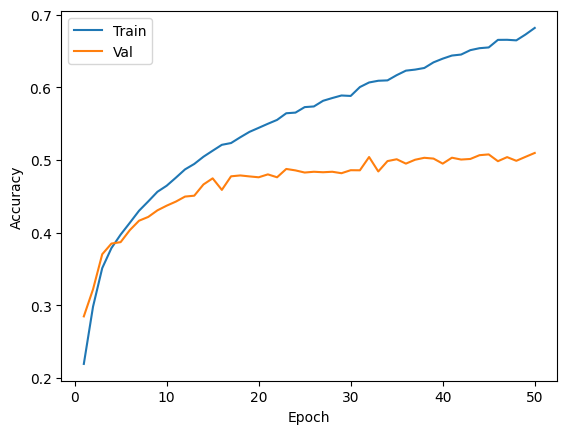

In [19]:
PlotGraph(Epoch_List, TrainAcc_List, ValAcc_List)

In [20]:
# -------------------------------------------- CIFAR-100 Dataset -----------------------------------------------------------
Option = 6
Train_DataLoader, Val_DataLoader, Test_DataLoader = CreateDataLoaders(Option, 64)
ModelName = "Model_MLP_IOCN_CIFAR100.pt"

model = MLP_IOCN(3072, 100).to(device)
loss_criteria = nn.CrossEntropyLoss()
AdamOpt = torch.optim.Adam(model.parameters(), lr=0.0001)

ValAccuracy = 0
TrainAcc_List = []
ValAcc_List = []

saved = False
if saved == True:
    saved_model = torch.load(ModelName, map_location=torch.device('cpu')).to(device)
else:
    model.train()
    Train_Accuracy = 0

    for e in range(EPOCHS):
        Train_Accuracy = TrainModel(model, loss_criteria, AdamOpt, device, Train_DataLoader)
        val_acc = EvaluateModel(model, Val_DataLoader, device)

        TrainAcc_List.append(Train_Accuracy.cpu().item())
        ValAcc_List.append(val_acc.cpu().item())

        print("EPOCH - ", e+1, ". Train Accuracy = ", Train_Accuracy.cpu().item(), ", Validation Accuracy = ", val_acc.cpu().item())
        
        if val_acc.cpu().item() > ValAccuracy:
            print("Model Re-Saved")
            ValAccuracy = val_acc.cpu().item()
            torch.save(model, ModelName)

    saved_model = torch.load(ModelName, map_location=torch.device('cpu')).to(device)


print()

Train_Accuracy = EvaluateModel(saved_model, Train_DataLoader, device)
print("Train Accuracy = ", Train_Accuracy.cpu().item())
Test_Accuracy = EvaluateModel(saved_model, Test_DataLoader, device)
print("Test Accuracy = ", Test_Accuracy.cpu().item())

print("Generalization Gap = ", (Train_Accuracy.cpu().item() - Test_Accuracy.cpu().item()))

100%|██████████| 169001437/169001437 [00:01<00:00, 104799782.02it/s]


Extracting ./cifar-100-python.tar.gz to ./
Files already downloaded and verified


100%|██████████| 118/118 [00:01<00:00, 88.17it/s]


EPOCH -  1 . Train Accuracy =  0.022658823058009148 , Validation Accuracy =  0.030666666105389595
Model Re-Saved


100%|██████████| 118/118 [00:01<00:00, 88.75it/s]


EPOCH -  2 . Train Accuracy =  0.03404705971479416 , Validation Accuracy =  0.036400001496076584
Model Re-Saved


100%|██████████| 118/118 [00:01<00:00, 87.95it/s]


EPOCH -  3 . Train Accuracy =  0.05416470766067505 , Validation Accuracy =  0.06613333523273468
Model Re-Saved


100%|██████████| 118/118 [00:01<00:00, 82.28it/s]


EPOCH -  4 . Train Accuracy =  0.08129411935806274 , Validation Accuracy =  0.08666666597127914
Model Re-Saved


100%|██████████| 118/118 [00:01<00:00, 84.86it/s]


EPOCH -  5 . Train Accuracy =  0.10694117844104767 , Validation Accuracy =  0.11213333159685135
Model Re-Saved


100%|██████████| 118/118 [00:01<00:00, 73.41it/s]


EPOCH -  6 . Train Accuracy =  0.12254117429256439 , Validation Accuracy =  0.12826666235923767
Model Re-Saved


100%|██████████| 118/118 [00:01<00:00, 68.23it/s]


EPOCH -  7 . Train Accuracy =  0.137058824300766 , Validation Accuracy =  0.14053332805633545
Model Re-Saved


100%|██████████| 118/118 [00:01<00:00, 90.61it/s]


EPOCH -  8 . Train Accuracy =  0.1456470638513565 , Validation Accuracy =  0.1393333375453949


100%|██████████| 118/118 [00:01<00:00, 87.26it/s]


EPOCH -  9 . Train Accuracy =  0.1584470570087433 , Validation Accuracy =  0.15146666765213013
Model Re-Saved


100%|██████████| 118/118 [00:01<00:00, 87.39it/s]


EPOCH -  10 . Train Accuracy =  0.16519999504089355 , Validation Accuracy =  0.15333333611488342
Model Re-Saved


100%|██████████| 118/118 [00:01<00:00, 87.17it/s]


EPOCH -  11 . Train Accuracy =  0.17209412157535553 , Validation Accuracy =  0.15986667573451996
Model Re-Saved


100%|██████████| 118/118 [00:01<00:00, 88.36it/s]


EPOCH -  12 . Train Accuracy =  0.17922353744506836 , Validation Accuracy =  0.1599999964237213
Model Re-Saved


100%|██████████| 118/118 [00:01<00:00, 87.96it/s]


EPOCH -  13 . Train Accuracy =  0.18432942032814026 , Validation Accuracy =  0.16680000722408295
Model Re-Saved


100%|██████████| 118/118 [00:01<00:00, 67.60it/s]


EPOCH -  14 . Train Accuracy =  0.18835294246673584 , Validation Accuracy =  0.1690666675567627
Model Re-Saved


100%|██████████| 118/118 [00:01<00:00, 75.39it/s]


EPOCH -  15 . Train Accuracy =  0.1941647082567215 , Validation Accuracy =  0.1733333319425583
Model Re-Saved


100%|██████████| 118/118 [00:01<00:00, 86.89it/s]


EPOCH -  16 . Train Accuracy =  0.20063529908657074 , Validation Accuracy =  0.18479999899864197
Model Re-Saved


100%|██████████| 118/118 [00:01<00:00, 88.75it/s]


EPOCH -  17 . Train Accuracy =  0.20364706218242645 , Validation Accuracy =  0.17640000581741333


100%|██████████| 118/118 [00:01<00:00, 87.40it/s]


EPOCH -  18 . Train Accuracy =  0.21068234741687775 , Validation Accuracy =  0.18466666340827942


100%|██████████| 118/118 [00:01<00:00, 87.81it/s]


EPOCH -  19 . Train Accuracy =  0.21541176736354828 , Validation Accuracy =  0.18573333323001862
Model Re-Saved


100%|██████████| 118/118 [00:01<00:00, 86.69it/s]


EPOCH -  20 . Train Accuracy =  0.21835294365882874 , Validation Accuracy =  0.19013333320617676
Model Re-Saved


100%|██████████| 118/118 [00:01<00:00, 86.54it/s]


EPOCH -  21 . Train Accuracy =  0.2249647080898285 , Validation Accuracy =  0.19493333995342255
Model Re-Saved


100%|██████████| 118/118 [00:01<00:00, 72.82it/s]


EPOCH -  22 . Train Accuracy =  0.22724705934524536 , Validation Accuracy =  0.1926666647195816


100%|██████████| 118/118 [00:01<00:00, 71.99it/s]


EPOCH -  23 . Train Accuracy =  0.23315294086933136 , Validation Accuracy =  0.19733333587646484
Model Re-Saved


100%|██████████| 118/118 [00:01<00:00, 89.40it/s]


EPOCH -  24 . Train Accuracy =  0.23465882241725922 , Validation Accuracy =  0.1998666673898697
Model Re-Saved


100%|██████████| 118/118 [00:01<00:00, 90.87it/s]


EPOCH -  25 . Train Accuracy =  0.24068234860897064 , Validation Accuracy =  0.1929333359003067


100%|██████████| 118/118 [00:01<00:00, 89.40it/s]


EPOCH -  26 . Train Accuracy =  0.2437882423400879 , Validation Accuracy =  0.19680000841617584


100%|██████████| 118/118 [00:01<00:00, 86.24it/s]


EPOCH -  27 . Train Accuracy =  0.24748235940933228 , Validation Accuracy =  0.1934666633605957


100%|██████████| 118/118 [00:01<00:00, 89.00it/s]


EPOCH -  28 . Train Accuracy =  0.25122353434562683 , Validation Accuracy =  0.20440000295639038
Model Re-Saved


100%|██████████| 118/118 [00:01<00:00, 87.71it/s]


EPOCH -  29 . Train Accuracy =  0.25611764192581177 , Validation Accuracy =  0.20080000162124634


100%|██████████| 118/118 [00:01<00:00, 66.16it/s]


EPOCH -  30 . Train Accuracy =  0.2569882273674011 , Validation Accuracy =  0.20880000293254852
Model Re-Saved


100%|██████████| 118/118 [00:01<00:00, 74.83it/s]


EPOCH -  31 . Train Accuracy =  0.26235294342041016 , Validation Accuracy =  0.20573332905769348


100%|██████████| 118/118 [00:01<00:00, 89.52it/s]


EPOCH -  32 . Train Accuracy =  0.2665646970272064 , Validation Accuracy =  0.21000000834465027
Model Re-Saved


100%|██████████| 118/118 [00:01<00:00, 89.91it/s]


EPOCH -  33 . Train Accuracy =  0.26875293254852295 , Validation Accuracy =  0.21066667139530182
Model Re-Saved


100%|██████████| 118/118 [00:01<00:00, 89.33it/s]


EPOCH -  34 . Train Accuracy =  0.2731058895587921 , Validation Accuracy =  0.20453333854675293


100%|██████████| 118/118 [00:01<00:00, 87.84it/s]


EPOCH -  35 . Train Accuracy =  0.2734352946281433 , Validation Accuracy =  0.21133333444595337
Model Re-Saved


100%|██████████| 118/118 [00:01<00:00, 86.50it/s]


EPOCH -  36 . Train Accuracy =  0.28103530406951904 , Validation Accuracy =  0.21266667544841766
Model Re-Saved


100%|██████████| 118/118 [00:01<00:00, 90.79it/s]


EPOCH -  37 . Train Accuracy =  0.2844941318035126 , Validation Accuracy =  0.20213334262371063


100%|██████████| 118/118 [00:01<00:00, 66.13it/s]


EPOCH -  38 . Train Accuracy =  0.285717636346817 , Validation Accuracy =  0.2173333317041397
Model Re-Saved


100%|██████████| 118/118 [00:01<00:00, 77.47it/s]


EPOCH -  39 . Train Accuracy =  0.2932470738887787 , Validation Accuracy =  0.21266667544841766


100%|██████████| 118/118 [00:01<00:00, 90.08it/s]


EPOCH -  40 . Train Accuracy =  0.29536470770835876 , Validation Accuracy =  0.21279999613761902


100%|██████████| 118/118 [00:01<00:00, 90.71it/s]


EPOCH -  41 . Train Accuracy =  0.29712942242622375 , Validation Accuracy =  0.20946666598320007


100%|██████████| 118/118 [00:01<00:00, 90.18it/s]


EPOCH -  42 . Train Accuracy =  0.30141177773475647 , Validation Accuracy =  0.21026666462421417


100%|██████████| 118/118 [00:01<00:00, 89.70it/s]


EPOCH -  43 . Train Accuracy =  0.30428236722946167 , Validation Accuracy =  0.2152000069618225


100%|██████████| 118/118 [00:01<00:00, 86.91it/s]


EPOCH -  44 . Train Accuracy =  0.3080235421657562 , Validation Accuracy =  0.21613334119319916


100%|██████████| 118/118 [00:01<00:00, 87.85it/s]


EPOCH -  45 . Train Accuracy =  0.31183528900146484 , Validation Accuracy =  0.21666666865348816


100%|██████████| 118/118 [00:01<00:00, 62.50it/s]


EPOCH -  46 . Train Accuracy =  0.31616470217704773 , Validation Accuracy =  0.2160000056028366


100%|██████████| 118/118 [00:01<00:00, 89.48it/s]


EPOCH -  47 . Train Accuracy =  0.3172941207885742 , Validation Accuracy =  0.21826666593551636
Model Re-Saved


100%|██████████| 118/118 [00:01<00:00, 87.27it/s]


EPOCH -  48 . Train Accuracy =  0.3202117681503296 , Validation Accuracy =  0.21746666729450226


100%|██████████| 118/118 [00:01<00:00, 91.11it/s]


EPOCH -  49 . Train Accuracy =  0.3259294033050537 , Validation Accuracy =  0.21746666729450226


100%|██████████| 118/118 [00:01<00:00, 84.69it/s]


EPOCH -  50 . Train Accuracy =  0.3299294114112854 , Validation Accuracy =  0.21293333172798157



100%|██████████| 665/665 [00:08<00:00, 80.08it/s]


Train Accuracy =  0.33289411664009094


100%|██████████| 157/157 [00:01<00:00, 89.72it/s]

Test Accuracy =  0.21529999375343323
Generalization Gap =  0.11759412288665771


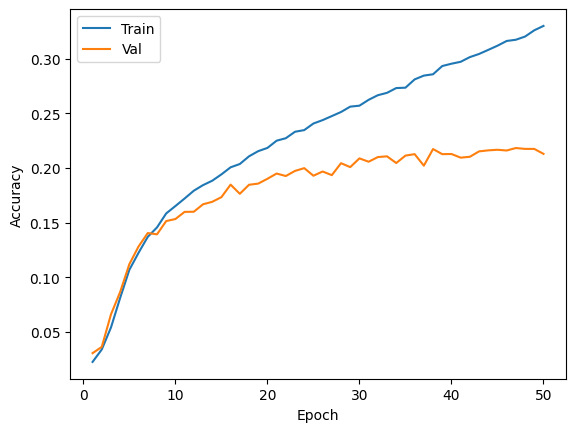

In [21]:
PlotGraph(Epoch_List, TrainAcc_List, ValAcc_List)